# imports and basic config

In [1]:
!pip install xgboost



[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from dataclasses import dataclass
from typing import List, Dict, Tuple
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler  # may use later

from xgboost import XGBClassifier

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


#Extract N-grams

#Exchange parameter dataclass + synthetic generator

In [3]:
@dataclass
class ExchangeParams:
    name: str
    base_rate_hz: float        # avg msgs/sec
    burstiness: float          # 0 = Poisson-ish, >0 = more clustered
    ack_rate: float            # P(ACK | NEW)
    nack_rate: float           # P(NACK | NEW)
    heartbeat_rate_hz: float   # heartbeats/sec


def simulate_exchange_stream(params: ExchangeParams,
                             duration_sec: float = 60.0,
                             seed: int = 42,
                             stream_id: str = "stream_0") -> pd.DataFrame:
    """
    More realistic synthetic exchange stream.
    Includes:
      - Poisson base flow
      - Burstiness (clusters)
      - Throttling waves (periodic sinusoidal)
      - Network jitter
      - Heartbeats
      - ACK/NACK responses with latency
      - Occasional seq_num anomalies (jumps)
    """
    rng = np.random.default_rng(seed)

    # Base Poisson events
    num_base_events = rng.poisson(params.base_rate_hz * duration_sec)
    event_times = np.sort(rng.uniform(0, duration_sec, size=num_base_events))

    # Burstiness: create small clusters
    if params.burstiness > 0:
        burst_idx = rng.choice(len(event_times),
                               int(params.burstiness * len(event_times)),
                               replace=False)
        burst_offsets = rng.exponential(scale=0.005, size=len(burst_idx))  # ~5ms
        event_times = np.sort(
            np.concatenate([event_times, event_times[burst_idx] + burst_offsets])
        )

    # Throttling waves (periodic distortion)
    throttle_amp = 0.002  # 2ms amplitude
    event_times = event_times + throttle_amp * np.sin(10 * event_times)

    # Network jitter (Gaussian noise, ~50µs)
    event_times = event_times + rng.normal(0, 0.00005, size=len(event_times))

    # Heartbeats as separate Poisson process
    num_heartbeats = rng.poisson(params.heartbeat_rate_hz * duration_sec)
    heartbeat_times = np.sort(rng.uniform(0, duration_sec, size=num_heartbeats))

    all_times = np.concatenate([event_times, heartbeat_times])
    base_types = np.concatenate([
        np.full(len(event_times), "NEW", dtype=object),
        np.full(len(heartbeat_times), "HEARTBEAT", dtype=object),
    ])

    # Sort by time
    order = np.argsort(all_times)
    all_times = all_times[order]
    base_types = base_types[order]

    rows = []
    seq_num = 1

    for t, tp in zip(all_times, base_types):
        rows.append((t, params.name, stream_id, tp, seq_num))

        # occasional seq_num jump to simulate anomalies
        if rng.uniform() < 0.001:
            seq_num += rng.integers(2, 6)
        else:
            seq_num += 1

        # For NEW messages, generate ACK or NACK with some latency
        if tp == "NEW":
            u = rng.uniform()
            response_delay = rng.exponential(scale=0.0003)  # ~300µs
            if u < params.ack_rate:
                rows.append((t + response_delay, params.name, stream_id, "ACK", seq_num))
                seq_num += 1
            elif u < params.ack_rate + params.nack_rate:
                rows.append((t + response_delay, params.name, stream_id, "NACK", seq_num))
                seq_num += 1

    df = pd.DataFrame(
        rows,
        columns=["timestamp_s", "exchange_id", "stream_id", "msg_type", "seq_num"]
    )
    df["timestamp_ns"] = (df["timestamp_s"] * 1e9).astype("int64")
    df = df.drop(columns=["timestamp_s"])
    return df


def simulate_multiple_exchanges(duration_sec: float = 120.0, seed: int = 42) -> pd.DataFrame:
    """
    Simulate multiple exchanges with different micro-behavior fingerprints.
    """
    configs: List[ExchangeParams] = [
        ExchangeParams(
            name="EX_A",
            base_rate_hz=500,
            burstiness=0.1,
            ack_rate=0.9,
            nack_rate=0.02,
            heartbeat_rate_hz=5,
        ),
        ExchangeParams(
            name="EX_B",
            base_rate_hz=300,
            burstiness=0.4,
            ack_rate=0.8,
            nack_rate=0.05,
            heartbeat_rate_hz=2,
        ),
        ExchangeParams(
            name="EX_C",
            base_rate_hz=700,
            burstiness=0.0,
            ack_rate=0.95,
            nack_rate=0.01,
            heartbeat_rate_hz=10,
        ),
    ]

    dfs = []
    for i, cfg in enumerate(configs):
        dfs.append(
            simulate_exchange_stream(
                cfg,
                duration_sec=duration_sec,
                seed=seed + i,
                stream_id=f"stream_{i}"
            )
        )

    full = pd.concat(dfs, ignore_index=True)
    full = full.sort_values("timestamp_ns").reset_index(drop=True)
    return full


#Generate data & peak

In [4]:
df = simulate_multiple_exchanges(duration_sec=120.0, seed=123)
df.head(), df["exchange_id"].value_counts()


(  exchange_id stream_id msg_type  seq_num  timestamp_ns
 0        EX_A  stream_0      NEW        1       1846998
 1        EX_C  stream_2      NEW        1       1857748
 2        EX_A  stream_0      ACK        2       1955923
 3        EX_C  stream_2      ACK        2       2382717
 4        EX_A  stream_0      NEW        3       2599927,
 exchange_id
 EX_C    166555
 EX_A    127703
 EX_B     93749
 Name: count, dtype: int64)

In [5]:
df["exchange_id"].value_counts()


exchange_id
EX_C    166555
EX_A    127703
EX_B     93749
Name: count, dtype: int64

#EDA

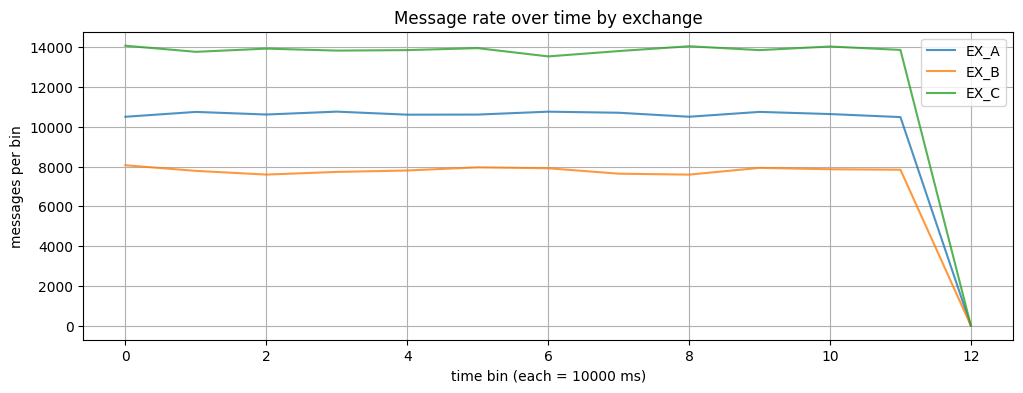

In [6]:
def plot_message_rate(df: pd.DataFrame, bin_ms: int = 10_000):
    bin_ns = bin_ms * 1_000_000
    tmp = df.copy()
    tmp["time_bin"] = (tmp["timestamp_ns"] // bin_ns).astype(int)
    grouped = tmp.groupby(["exchange_id", "time_bin"]).size().reset_index(name="count")

    plt.figure(figsize=(12, 4))
    for ex_id, g in grouped.groupby("exchange_id"):
        plt.plot(g["time_bin"], g["count"], label=ex_id, alpha=0.8)
    plt.xlabel(f"time bin (each = {bin_ms} ms)")
    plt.ylabel("messages per bin")
    plt.title("Message rate over time by exchange")
    plt.legend()
    plt.show()

plot_message_rate(df)


#window logic

In [7]:
def make_windows(df: pd.DataFrame,
                 window_size: int = 256,
                 stride: int = 128) -> List[Tuple[pd.DataFrame, str]]:
    """
    Slice streams into overlapping windows of fixed message count.
    Returns list of (window_df, exchange_id).
    """
    windows: List[Tuple[pd.DataFrame, str]] = []
    for (ex_id, stream_id), group in df.groupby(["exchange_id", "stream_id"]):
        group = group.sort_values("timestamp_ns").reset_index(drop=True)
        n = len(group)
        i = 0
        while i + window_size <= n:
            window_df = group.iloc[i:i+window_size].copy()
            windows.append((window_df, ex_id))
            i += stride
    return windows

windows = make_windows(df, window_size=256, stride=128)
len(windows), windows[0][0].head(), windows[0][1]


(3027,
   exchange_id stream_id msg_type  seq_num  timestamp_ns
 0        EX_A  stream_0      NEW        1       1846998
 1        EX_A  stream_0      ACK        2       1955923
 2        EX_A  stream_0      NEW        3       2599927
 3        EX_A  stream_0      ACK        4       2711800
 4        EX_A  stream_0      NEW        5       9697816,
 'EX_A')

In [8]:
sample_window, sample_label = windows[0]
sample_window.head(), sample_label


(  exchange_id stream_id msg_type  seq_num  timestamp_ns
 0        EX_A  stream_0      NEW        1       1846998
 1        EX_A  stream_0      ACK        2       1955923
 2        EX_A  stream_0      NEW        3       2599927
 3        EX_A  stream_0      ACK        4       2711800
 4        EX_A  stream_0      NEW        5       9697816,
 'EX_A')

#Feature extraction

In [9]:
def interarrival_features(window_df: pd.DataFrame,
                          max_fft_bins: int = 20) -> Dict[str, float]:
    """
    Inter-arrival stats + low-frequency FFT magnitudes.
    """
    ts = np.sort(window_df["timestamp_ns"].to_numpy())
    ia = np.diff(ts) / 1e3  # microseconds

    feats: Dict[str, float] = {}

    if len(ia) == 0:
        for k in ["mean", "std", "min", "max", "q25", "q50", "q75"]:
            feats[f"ia_{k}"] = 0.0
        return feats

    feats["ia_mean"] = float(np.mean(ia))
    feats["ia_std"]  = float(np.std(ia))
    feats["ia_min"]  = float(np.min(ia))
    feats["ia_max"]  = float(np.max(ia))
    feats["ia_q25"]  = float(np.quantile(ia, 0.25))
    feats["ia_q50"]  = float(np.quantile(ia, 0.50))
    feats["ia_q75"]  = float(np.quantile(ia, 0.75))

    # FFT of centered inter-arrival
    ia_centered = ia - np.mean(ia)
    n = len(ia_centered)
    n_fft = 1 << (n - 1).bit_length()  # next power of 2
    ia_padded = np.zeros(n_fft)
    ia_padded[:n] = ia_centered

    mag = np.abs(np.fft.rfft(ia_padded))
    num_bins = min(max_fft_bins, len(mag))
    for k in range(num_bins):
        feats[f"ia_fft_mag_{k}"] = float(mag[k])

    return feats


#Message-Type ngrams

In [10]:
def msgtype_ngrams(window_df: pd.DataFrame,
                   ngram_range=(1, 2)) -> Dict[str, float]:
    """
    1-gram (unigram) and 2-gram (bigram) frequencies of msg_type.
    Normalized by counts.
    """
    seq = window_df["msg_type"].tolist()
    feats: Dict[str, float] = {}

    # unigrams
    unigram_counts = Counter(seq)
    total = len(seq)
    for k, v in unigram_counts.items():
        feats[f"uni_{k}"] = v / total if total > 0 else 0.0

    # bigrams
    if ngram_range[1] >= 2 and len(seq) >= 2:
        bigrams = [(seq[i], seq[i+1]) for i in range(len(seq)-1)]
        bigram_counts = Counter(bigrams)
        total_bi = len(bigrams)
        for (a, b), v in bigram_counts.items():
            feats[f"bi_{a}_{b}"] = v / total_bi if total_bi > 0 else 0.0

    return feats


#ACK/NACK Latency Features

In [11]:
def ack_latency_features(window_df: pd.DataFrame) -> Dict[str, float]:
    """
    Approximate NEW->ACK/NACK latency stats:
    For each ACK/NACK, subtract timestamp of last NEW before it.
    """
    feats: Dict[str, float] = {}

    dfw = window_df.sort_values("timestamp_ns").reset_index(drop=True)
    last_new_time = None
    latencies_ack = []
    latencies_nack = []

    for _, row in dfw.iterrows():
        msg_type = row["msg_type"]
        t = row["timestamp_ns"]
        if msg_type == "NEW":
            last_new_time = t
        elif msg_type in ("ACK", "NACK") and last_new_time is not None:
            dt_us = (t - last_new_time) / 1e3
            if msg_type == "ACK":
                latencies_ack.append(dt_us)
            else:
                latencies_nack.append(dt_us)

    def add_stats(prefix: str, arr: List[float]):
        if len(arr) == 0:
            feats[f"{prefix}_mean"] = 0.0
            feats[f"{prefix}_std"] = 0.0
            return
        arr_np = np.array(arr)
        feats[f"{prefix}_mean"] = float(np.mean(arr_np))
        feats[f"{prefix}_std"] = float(np.std(arr_np))

    add_stats("ack_lat", latencies_ack)
    add_stats("nack_lat", latencies_nack)

    feats["ack_count"] = float(len(latencies_ack))
    feats["nack_count"] = float(len(latencies_nack))

    return feats


Sequence-Number Anomally Features

In [12]:
def seqnum_anomaly_features(window_df: pd.DataFrame) -> Dict[str, float]:
    """
    Look at seq_num gaps and backwards movement.
    """
    feats: Dict[str, float] = {}
    seq = window_df["seq_num"].to_numpy()
    diffs = np.diff(seq)
    if len(diffs) == 0:
        feats["seq_jump_rate"] = 0.0
        feats["seq_backwards_rate"] = 0.0
        return feats

    jumps = diffs > 1
    backwards = diffs <= 0
    feats["seq_jump_rate"] = float(np.mean(jumps))
    feats["seq_backwards_rate"] = float(np.mean(backwards))
    return feats


Combined feature Extractor

In [13]:
def extract_features(window_df: pd.DataFrame) -> Dict[str, float]:
    feats: Dict[str, float] = {}
    feats.update(interarrival_features(window_df, max_fft_bins=20))
    feats.update(msgtype_ngrams(window_df, ngram_range=(1, 2)))
    feats.update(ack_latency_features(window_df))
    feats.update(seqnum_anomaly_features(window_df))
    return feats

# quick sanity check
sample_window, sample_label = windows[0]
extract_features(sample_window)


{'ia_mean': 1053.6038235294118,
 'ia_std': 1606.2315873551117,
 'ia_min': 2.58,
 'ia_max': 10245.417,
 'ia_q25': 113.51750000000001,
 'ia_q50': 388.357,
 'ia_q75': 1169.971,
 'ia_fft_mag_0': 7.275957614183426e-12,
 'ia_fft_mag_1': 26134.964104410035,
 'ia_fft_mag_2': 14940.422054496183,
 'ia_fft_mag_3': 7564.674698825521,
 'ia_fft_mag_4': 30242.50186107787,
 'ia_fft_mag_5': 18869.913938331978,
 'ia_fft_mag_6': 8032.236850947833,
 'ia_fft_mag_7': 17155.954461018402,
 'ia_fft_mag_8': 13795.32702869648,
 'ia_fft_mag_9': 31422.32836224123,
 'ia_fft_mag_10': 11714.2583636829,
 'ia_fft_mag_11': 30534.684060748456,
 'ia_fft_mag_12': 22515.142344688327,
 'ia_fft_mag_13': 19754.493741435625,
 'ia_fft_mag_14': 25237.435015870484,
 'ia_fft_mag_15': 13062.421959015957,
 'ia_fft_mag_16': 13264.904764613788,
 'ia_fft_mag_17': 37641.9083092555,
 'ia_fft_mag_18': 31688.039536116725,
 'ia_fft_mag_19': 15993.317598272066,
 'uni_NEW': 0.5234375,
 'uni_ACK': 0.46875,
 'uni_HEARTBEAT': 0.00390625,
 'uni_NA

#Build Dataset (X, y)

In [14]:
def build_dataset(duration_sec: float = 120.0,
                  window_size: int = 256,
                  stride: int = 128,
                  seed: int = 123):
    df = simulate_multiple_exchanges(duration_sec=duration_sec, seed=seed)
    windows = make_windows(df, window_size=window_size, stride=stride)

    feature_rows: List[Dict[str, float]] = []
    labels: List[str] = []

    for window_df, ex in windows:
        feature_rows.append(extract_features(window_df))
        labels.append(ex)

    feat_df = pd.DataFrame(feature_rows).fillna(0.0)
    X = feat_df.to_numpy(dtype=float)
    y = np.array(labels)

    return df, feat_df, X, y


df, feat_df, X, y = build_dataset()
X.shape, np.unique(y), feat_df.head()


((3027, 55),
 array(['EX_A', 'EX_B', 'EX_C'], dtype='<U4'),
        ia_mean       ia_std  ia_min     ia_max    ia_q25   ia_q50     ia_q75  \
 0  1053.603824  1606.231587   2.580  10245.417  113.5175  388.357  1169.9710   
 1   959.617141  1599.775350   2.580  10245.417  112.1795  302.033   997.6980   
 2   949.910220  1499.821081   0.479   7772.338  112.0220  311.523  1129.0345   
 3   942.693510  1329.188811   0.479   7472.670  113.3175  392.204  1278.8640   
 4   914.275153  1299.733954   1.066   8237.749  118.8275  424.164  1126.9165   
 
    ia_fft_mag_0  ia_fft_mag_1  ia_fft_mag_2  ...  seq_jump_rate  \
 0  7.275958e-12  26134.964104  14940.422054  ...       0.156863   
 1  0.000000e+00   9156.706473  21228.239826  ...       0.156863   
 2  2.910383e-11  23319.376568  21244.538119  ...       0.152941   
 3  7.275958e-12  10556.404575  20050.266053  ...       0.098039   
 4  9.094947e-12   9015.991854  14413.434483  ...       0.062745   
 
    seq_backwards_rate  bi_NACK_ACK  bi_AC

#Train XGBoost Classifier

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
)

model.fit(X_train, y_train_encoded)

y_pred_encoded = model.predict(X_test)

# Convert back to original labels for reporting
y_pred = le.inverse_transform(y_pred_encoded)
y_test_original = le.inverse_transform(y_test_encoded)

print("Classification report:")
print(classification_report(y_test_original, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test_original, y_pred, labels=le.classes_))


Classification report:
              precision    recall  f1-score   support

        EX_A       0.95      0.91      0.93       249
        EX_B       0.99      0.99      0.99       183
        EX_C       0.94      0.97      0.95       325

    accuracy                           0.96       757
   macro avg       0.96      0.96      0.96       757
weighted avg       0.96      0.96      0.96       757

Confusion matrix:
[[227   2  20]
 [  1 182   0]
 [ 10   0 315]]


#Feature importance

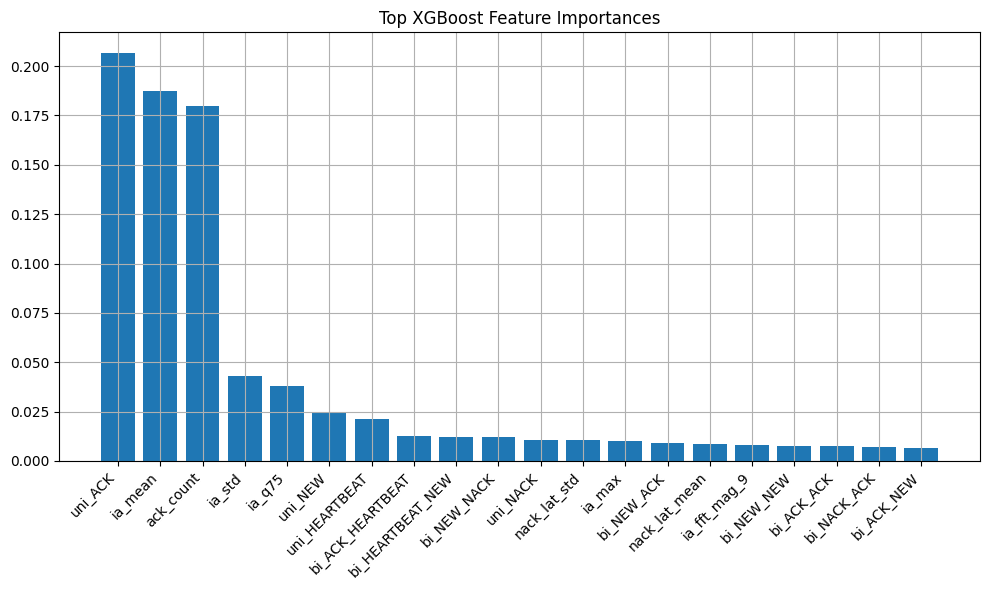

In [16]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20

plt.figure(figsize=(10, 6))
plt.bar(range(top_k), importances[indices[:top_k]])
plt.xticks(range(top_k), feat_df.columns[indices[:top_k]], rotation=45, ha="right")
plt.title("Top XGBoost Feature Importances")
plt.tight_layout()
plt.show()


Saving model

In [19]:
import os
import json

os.makedirs("data/models", exist_ok=True)
os.makedirs("data/metadata", exist_ok=True)

# Save the model
model.save_model("data/models/xgb_exchange_fp.json")

# Get feature names from feat_df (the DataFrame), not X_train (numpy array)
feature_names = list(feat_df.columns)
with open("data/metadata/feature_names.json", "w") as f:
    json.dump(feature_names, f)